1. Intro about the data
2. Data import and exploration (train) [take ideas from my github] - remember about outliers
3. Data preprocessing (one-hot, regularisation, etc)
4. Feature engineering
5. Model selection and Rationale
5.1. Shallow learning
5.2. Deep learning (see tensorflow models I did for andrew as an inspiration)

6. Compare results with the leaderboard, submit results.

#### Ideas: 
    - [DONE] Consider converting time to a continuous variable that'd take into account that 00:01 is closer to 23:59 than to 00:10 ( test accuracy with and without it)
    
    - Consider doing the deep learning spiel in a separate file, using a preprocessed data achieved in this file (prob more efficient for use in floydhub)
    - Consider using tools for finding sensible parameters 
    
    - Consider making predictions for registered an casual separately, and then combining the scores.
    - Consider taking log of dependent variables
    - Consider removing outliers from 'count'
  

#### 1. Introduction

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


Variables included in the data: 

    datetime   - hourly date + timestamp  
    
    season     -  1 = spring,
                  2 = summer,
                  3 = fall,
                  4 = winter 
                  
    holiday    - whether the day is considered a holiday
    
    workingday - whether the day is neither a weekend nor holiday
    
    weather    -  1: Clear, Few clouds, Partly cloudy, Partly cloudy 
                  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
                  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
                 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
                 
    temp       - temperature in Celsius
    
    atemp      - "feels like" temperature in Celsius
    
    humidity   - relative humidity
    
    windspeed  - wind speed
    
    casual     - number of non-registered user rentals initiated
    
    registered - number of registered user rentals initiated
    
    count      - number of total rentals

#### 2. Data import and exploration

In [297]:
data = pd.read_csv("./data/train.csv")

In [298]:
data.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### 3. Preprocessing and feature extraction

   

Let's import the train and test datasets.

In [299]:
train_df = pd.read_csv("./data/train.csv") 
test_df = pd.read_csv("./data/test.csv") 
combined_df = [train_df, test_df] #combined datasets - I'll use this in loops replacing values in both datasets 

Let's look at descriptive statistics of this dataset to see if there are any outliers, or data that seems to be erroneous entries.

In [300]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [301]:
# The relative humidity level seems odd and is suggestive of presence of outliers. I'll look into this later.

In [302]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity 

Excellent, no missing data!

Before we go on and transform the data, let's run a Pearson correlation matrix to see if there are any bivariate correlations worth looking into in more detail.

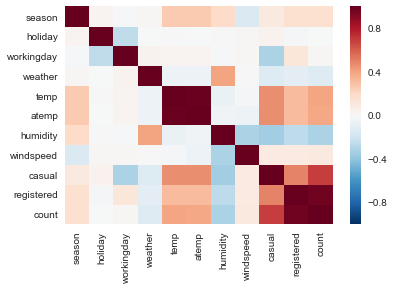

In [303]:
import seaborn as sns
corr = train_df.corr(method='pearson')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

As one might expect, count of bike-users correlates with air temperature (and "feels like"-temperature), humidity (which is itself highly correlated with the categorical variable describing the weather).

Let's look at some of the variables individually to understand the data better and see if there are any outliers

datetime    
season
holiday
workingday 
weather                     
temp         
atemp          
humidity  
windspeed

casual  
registered 
count


(A) datetime

In [304]:
train_df["datetime"].head()

0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: datetime, dtype: object

We can use a fantastic pandas function to extract days of the month/week, years, hours, and assign them to new features

In [305]:
for df in combined_df:
    date = pd.DatetimeIndex(df['datetime'])

    df['month'] = date.month
    df['year'] = date.year
    df['hour'] = date.hour
    df['day_of_week'] = date.dayofweek

    # # Let's encode hours, months, and days of the week to preserve their cyclical nature 
    # # I got this idea from https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes
    df['hour_sin'] = np.sin(df.hour*(2.*np.pi/24))
    df['hour_cos'] = np.cos(df.hour*(2.*np.pi/24))

    df['dow_sin'] = np.sin(df.day_of_week*(2.*np.pi/7))
    df['dow_cos'] = np.cos(df.day_of_week*(2.*np.pi/7))

    df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))
    
    


    df.drop('datetime', axis = 1, inplace = True)


(B) Humidity

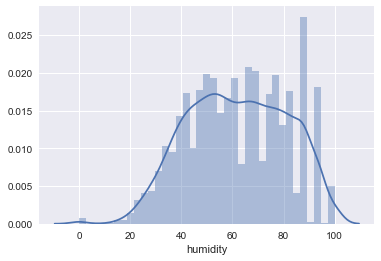

In [306]:
sns.distplot(train_df["humidity"])
# train_df.groupby('humidity').humidity.count()[0]
# train_df.groupby('humidity').humidity.count()[100]

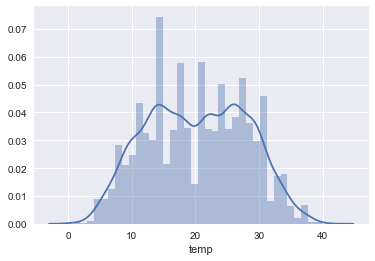

In [307]:
sns.distplot(train_df["temp"])


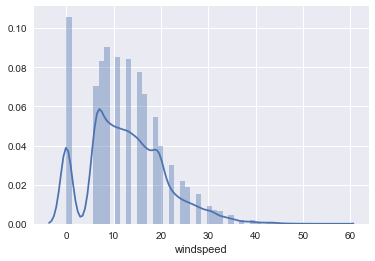

In [308]:
sns.distplot(train_df["windspeed"])


Windspeed is odd, too. Windspeed of 0 is generally unlikely to occur. This may mean the device collecting the data is very insensitive to wind slower than 6km/h and assigning value of 0 to these. 

///// imputting windspeed &  humidity??


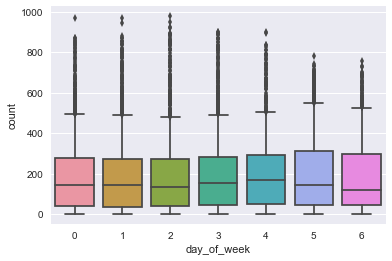

In [309]:
ax = sns.boxplot(x="day_of_week", y="count", data=train_df, whis=0.9)


// add graph showing that subgroups of bikers (registered vs casual) differ in when they go cycling - regular commuting hours vs bigger propensity to cycle during the weekend.

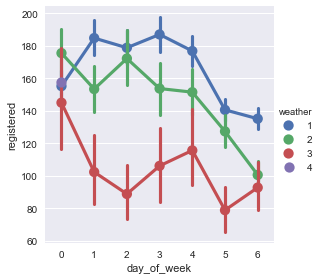

In [310]:
sns.factorplot(data = train_df,
               x = 'day_of_week',
               y = "registered", 
               hue = 'weather',
               ) 

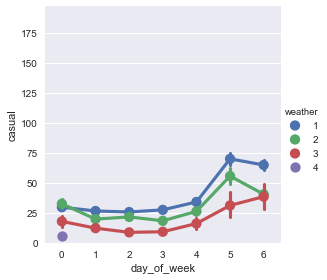

In [311]:
g= sns.factorplot(data = train_df,
               x = 'day_of_week',
               y = "casual", 
               hue = 'weather',
               ) 

(g.set(ylim=(0, train_df.registered.quantile(0.7))))

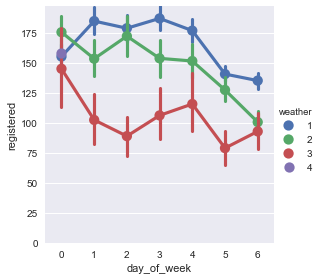

In [312]:
g= sns.factorplot(data = train_df,
               x = 'day_of_week',
               y = "registered", 
               hue = 'weather',
               ) 

(g.set(ylim=(0, train_df.registered.quantile(0.7))))

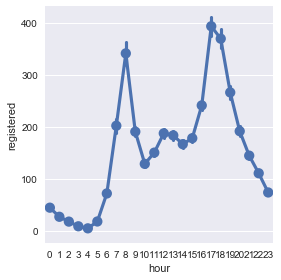

In [313]:
g= sns.factorplot(data = train_df,
               x = 'hour',
               y = "registered", 
               ) 



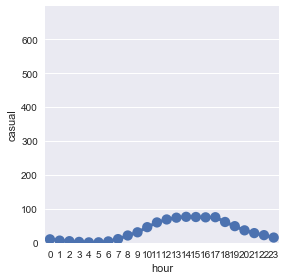

In [314]:
g= sns.factorplot(data = train_df,
               x = 'hour',
               y = "casual", 
               ) 
(g.set(ylim=(0, train_df.registered.quantile(0.99
                                            ))))

It appears that registered users and casual users have different usage patterns of city bikes.
Registered users use rental bikes disproportionately more during commuting hours (7-8am and 5-7pm), whereas casual cyclists' hourly usage usage patterns are more regular, peaking between 12pm and 4pm.

I think that observation in itself warrants running two separate models for casual and registered users and using the sum of the two predictions as the final 'count' dependent variable. Nonetheless, let's see if we can observe differences in usage patterns in weekly (day_of_week), monthly (month) timeframes. 

Additionally, we'll look at the relationship between the temperature and the demand for these two user groups. 

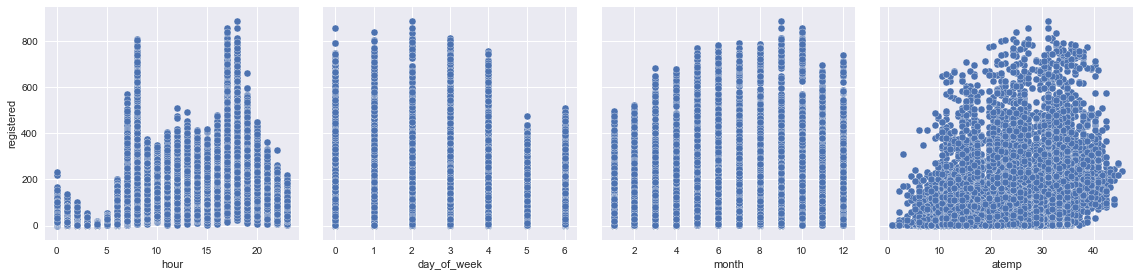

In [315]:
import seaborn as sns
sns.pairplot(train_df, x_vars=['hour', 'day_of_week','month', 'atemp'], y_vars='registered', diag_kind = 'hist', palette="Set3", aspect=1, size=4)

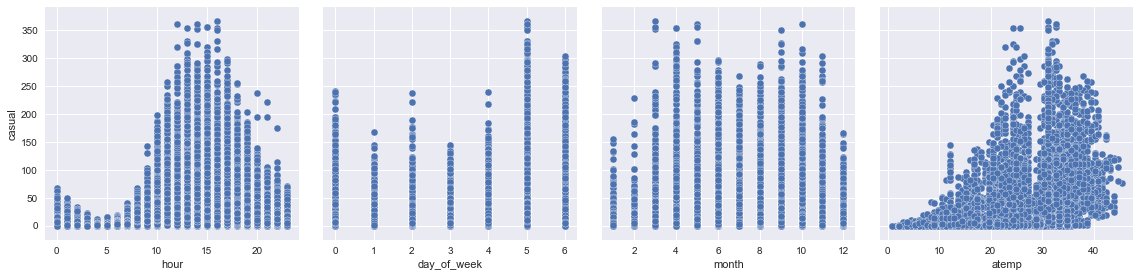

In [316]:
import seaborn as sns
sns.pairplot(train_df, x_vars=['hour', 'day_of_week','month', 'atemp'], y_vars='casual', palette="Set3",aspect=1, size=4)

Awesome! Two additional things I noticed from the comparison between the two user groups is:

- There is an apparent difference between demand on workdays vs weekends (casual users appear to be more keen to cycle on the weekends than on the workdays - the reverse is true for registered users)
- Registered users appear to be less sensitive to low temperatures (no wonder; cycling commuters are a resilient bunch!)

In [317]:
def onehot_encode(df, varlist, drop_org = True):
    
        for var in varlist:
            dummies =  pd.get_dummies(df[var], prefix=var, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)
            df = pd.concat([df, dummies], axis=1)
            df.drop(var, inplace = True, axis=1)
        return df

In [318]:
to_onehot_encode = ['season',
                    'weather',
                    'year']

train_df = onehot_encode(df = train_df, varlist = to_onehot_encode)
test_df = onehot_encode(df = test_df, varlist = to_onehot_encode)

Dropping unnecessary variables...

In [319]:
to_drop = ['temp', 'windspeed', 'month','hour','day_of_week']
train_df.drop(to_drop, inplace = True, axis = 1)
test_df.drop(to_drop, inplace = True, axis = 1)

In [320]:
# regrCasual = linear_model.LinearRegression()
# regrRegistered = linear_model.LinearRegression()
# regrCasual.fit(trainX, trainYCasual)
# regrRegistered.fit(trainX, trainYRegistered)
# predicted = regrCasual.predict(testX) +regrRegistered.predict(testX)

In [321]:

# to_drop_train = ['casual', 'registered']
# train_df.drop(to_drop_train, inplace = True, axis = 1)


In [322]:
train_df.keys()

Index(['holiday', 'workingday', 'atemp', 'humidity', 'casual', 'registered',
       'count', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin',
       'month_cos', 'season_1', 'season_2', 'season_3', 'season_4',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'year_2011',
       'year_2012'],
      dtype='object')

In [323]:
test_df.keys()

Index(['holiday', 'workingday', 'atemp', 'humidity', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'year_2011', 'year_2012'],
      dtype='object')

#### 4. Modelling

Let's split our training data into a train set and a validation set; X_train, X_validate, Y_train, Y_validate will be the datasets I'll use for measuring accuracy of the models.

In [326]:
Y = train_df["count"]
X = train_df.drop(["count"], axis = 1)

In [327]:
X.keys()

Index(['holiday', 'workingday', 'atemp', 'humidity', 'casual', 'registered',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'year_2011', 'year_2012'],
      dtype='object')

In [328]:
Y.keys()

Index(['count', 'registered', 'casual'], dtype='object')

In [329]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X,Y, test_size=0.3, random_state=2)


Models to be used...

I'll test the following classifiers:

    [DONE] Linear regression
    Lasso
    Elasticnet???
    RidgeRegression
    SVRkernel linear
    Ensemble regressors 

    xgboost

    Neural network (tensorflow)
    
    
Their choice was based mainly on the incredibly informative map of algorithms found on the official sklearn site: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

But before we start training our models, let's make a helper function that will calculate the root mean squared log error scores for each of our classifiers.




In [290]:
def rmsle(h, y): 
    """
    This function computes the Root Mean Squared Log Error for hypothesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

I'm guessing it's unlikely there's a clear linear relationship between the independent variables and the dependent variable, but let's start off with running a linear regression model. It will give us an idea about the validity of our   and Let's start off with a linear regression to get an idea if things are 

In [291]:
from sklearn.linear_model import LinearRegression

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = X_train, y = np.log1p(y_train))

# Make predictions
preds_t = lModel.predict(X= X_train)
preds_v = lModel.predict(X= X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))


RMSLE Value For Linear Regression In Training:  0.62650577888
RMSLE Value For Linear Regression In Validation:  0.613486629947


That's a surprisingly good result for a linear regression, but still nowhere near the kind of score I should be aiming at.

In [292]:
from sklearn.model_selection import GridSearchCV
import xgboost as xg
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestRegressor


In [293]:
import xgboost as xg

xgr=xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0,colsample_bytree=0.9,subsample=0.9) #Kaggle score - 0.460
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

RMSLE Value For Linear Regression In Training:  0.0157236672975
RMSLE Value For Linear Regression In Validation:  0.0291082874197


The xgboost achieved a sensible score of 0.460 on Kaggle, after I fiddled with the parameters a little bit. Let's save this submission and see how a random forest regressor will do in this scenario

In [294]:
test_pred1 = (np.exp(xgr.predict(test_df)))

df = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':df, 'count':test_pred1})

df.to_csv('submission1', index = False, columns=['datetime','count'])

ValueError: feature_names mismatch: ['holiday', 'workingday', 'atemp', 'humidity', 'casual', 'registered', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'year_2011', 'year_2012'] ['holiday', 'workingday', 'atemp', 'humidity', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'year_2011', 'year_2012']
expected registered, casual in input data

In [93]:
xgr = RandomForestRegressor(max_depth=20, n_estimators=1000, max_features=10)
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

RMSLE Value For Linear Regression In Training:  0.105800832797
RMSLE Value For Linear Regression In Validation:  0.29136842053


Random forest regressor achieved a surprisingly good result on the leaderboard 0.44959

In [ ]:
test_pred1 = (np.exp(xgr.predict(test_df)))

dt = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':dt, 'count':test_pred1})

df.to_csv('submission4', index = False, columns=['datetime','count'])

#### 5. Conclusion

Check to be performed with rmsle:  
    


# DUMPSTER

In [ ]:
#     dataTrain  = dataTrain.drop(dropFeatures,axis=1)
# dataTest  = dataTest.drop(dropFeatures,axis=1)
# X_train = X_train.drop(dropFeatures,axis=1)
# X_validate = X_validate.drop(dropFeatures,axis=1)

In [ ]:
# from sklearn.model_selection import GridSearchCV



# xgr=xg.XGBRegressor()
# xgr.fit(X = X_train, y = np.log1p(y_train))



# parameters =[{'max_depth':[8,9,10,11,12],
#               'min_child_weight':[4,5,6,7,8],
#               'gamma':[i/10.0 for i in range(0,5)],
#               'subsample':[i/10.0 for i in range(6,10)],
#               'colsample_bytree':[i/10.0 for i in range(6,10)]}]
             
        



# grid_search= GridSearchCV(estimator=xgr, param_grid=parameters, cv=10, n_jobs=-1)


# print (1)
# grid_search=grid_search.fit(X = X_train, y = np.log1p(y_train))
# print (2)
# best_accuracy=grid_search.best_score_
# best_parameters=grid_search.best_params_
# print (best_accuracy)
# print (best_parameters)



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) ### Test 0.44
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_validate)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds)))

In [ ]:
import xgboost as xg

xgr1=xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0.5,colsample_bytree=0.9,subsample=0.9)
xgr1.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr1.predict(X_train)
preds_v = xgr1.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

In [ ]:
# params = {
#     # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     'eval_metric': 'mae',
#     # Other parameters
#     'objective':'reg:linear'
# }

In [ ]:
# num_boost_round = 999


In [ ]:
# LINEAR MODEL


# from sklearn import linear_model
# reg = linear_model.Lasso(alpha = 0.01, )

# reg.fit(X = X_train, y = y_train)

# # Make predictions
# preds_t = reg.predict(X= X_train)
# preds_v = reg.predict(X= X_validate)
# print ("RMSLE Value For Linear Regression In Training: ",rmsle((y_train),(preds_t)))
# print ("RMSLE Value For Linear Regression In Validation: ",rmsle((y_validate),(preds_v)))




In [ ]:
import xgboost as xg

xgr=xg.XGBRegressor(max_depth=8,min_child_weight=4,gamma=0,colsample_bytree=0.9,subsample=0.9)
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

Leaderboard score: 0.47777

In [ ]:

sns.stripplot(train_df["day_of_week"]+1, train_df["count"], jitter=0.45,  palette="Set3")

In [ ]:
test_pred = (np.exp(xgr.predict(test_df)))

dt = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':dt, 'count':test_pred})

df.to_csv('submission1', index = False, columns=['datetime','count'])

In [ ]:
STOP

{'max_depth': 8, 'min_child_weight': 4}'''
{'gamma': 0.0}
{'colsample_bytree': 0.9, 'subsample': 0.9}


In [ ]:
xgr=xg.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4)
xgr.fit(X = X_train, y = np.log1p(y_train))



# parameters=[{'max_depth':[8,9,10,11,12],'min_child_weight':[4,5,6,7,8]}]
'''
0.999889269652
{'max_depth': 8, 'min_child_weight': 4}'''


# parameters=[{'gamma':[i/10.0 for i in range(0,5)]}]
'''

0.99999526338
{'gamma': 0.0}
'''
# parameters=[{'subsample':[i/10.0 for i in range(6,10)],
# 'colsample_bytree':[i/10.0 for i in range(6,10)]}]

# '''
# 0.999770012926
# {'colsample_bytree': 0.9, 'subsample': 0.9}
# '''
# grid_search= GridSearchCV(estimator=xgr, param_grid=parameters, cv=10,n_jobs=-1)


# print (1)
# grid_search=grid_search.fit(X = X_train, y = np.log1p(y_train))
# print (2)
# best_accuracy=grid_search.best_score_
# best_parameters=grid_search.best_params_
# print (best_accuracy)
# print (best_parameters)



In [ ]:
import xgboost as xg

xgr=xg.XGBRegressor(max_depth=20, n_estimators=1000, max_features=10)
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

In [ ]:
test_pred6 = (np.exp(xgr.predict(test_df)))

dt = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':dt, 'count':test_pred6})

df.to_csv('submission6', index = False, columns=['datetime','count'])

In [ ]:
import xgboost as xg

xgr=xg.XGBRegressor(n_estimators = 600,max_depth=6,min_child_weight=5,gamma=0,colsample_bytree=1,subsample=0.85, num_round = 600, learning_rate = 0.07)
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

above -> XGBOOST #3 with adjusted hyperparameters

In [ ]:
test_pred2 = (np.exp(xgr.predict(test_df)))

dt = pd.read_csv("./data/test.csv")['datetime']
df = pd.DataFrame({'datetime':dt, 'count':test_pred2})

df.to_csv('submission3', index = False, columns=['datetime','count'])

In [ ]:
import xgboost as xg

xgr=xg.XGBRegressor(max_depth=8,min_child_weight=3,gamma=0,colsample_bytree=0.9,subsample=0.9)
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

In [ ]:
import xgboost as xg

xgr=xg.XGBRegressor(max_depth=8,min_child_weight=3,gamma=0,colsample_bytree=0.9,subsample=0.9)
xgr.fit(X = X_train, y = np.log1p(y_train))

preds_t = xgr.predict(X_train)
preds_v = xgr.predict(X_validate)
print ("RMSLE Value For Linear Regression In Training: ",rmsle(np.exp(preds_t),np.exp(np.log1p(y_train))))
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds_v)))

XGBOOST #2 with cyclical dates